참고 소스 : https://github.com/therealcyberlord/coronavirus_visualization_and_prediction/blob/master/coronavirus-covid-19-visualization-prediction.ipynb

데이터 : https://github.com/CSSEGISandData/COVID-19

홉킨스 데이터는 매일 9시 정도에 업데이트 됨

In [0]:
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
import datetime
import operator
plt.style.use('seaborn')
%matplotlib inline


In [2]:
# 존스 홉킨스 데이터 다운로드
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19


In [3]:
cols = confirmed_df.keys()
cols

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
       '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
       '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20',
       '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20',
       '3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20',
       '3/27/20', '3/28/20', '3/29/20', '3/30/20', '3/31/20', '4/1/20',
       '4/2/20', '4/3/20', '4/4/20', '4/5/20', '4/6/20', '4/7/20', '4/8/20'],
      dtype='object')

In [0]:
# 일일 데이터만 추출('Province/State', 'Country/Region', 'Lat', 'Long' 컬럼 제외)
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]


In [5]:
dates = confirmed.keys()
print(dates)
adjusted_dates = np.array([i for i in range(len(dates))]).reshape(-1, 1)


Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20',
       '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20',
       '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20',
       '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', '2/21/20',
       '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20',
       '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20', '3/4/20', '3/5/20',
       '3/6/20', '3/7/20', '3/8/20', '3/9/20', '3/10/20', '3/11/20', '3/12/20',
       '3/13/20', '3/14/20', '3/15/20', '3/16/20', '3/17/20', '3/18/20',
       '3/19/20', '3/20/20', '3/21/20', '3/22/20', '3/23/20', '3/24/20',
       '3/25/20', '3/26/20', '3/27/20', '3/28/20', '3/29/20', '3/30/20',
       '3/31/20', '4/1/20', '4/2/20', '4/3/20', '4/4/20', '4/5/20', '4/6/20',
       '4/7/20', '4/8/20'],
      dtype='object')


In [0]:
latest_confirmed = confirmed_df[dates[-1]]
latest_deaths = deaths_df[dates[-1]]
latest_recoveries = recoveries_df[dates[-1]]


In [7]:
# 국가 리스트 및 국가별 인구 수
TOP_N = 17  # 확진자 상위 국가 N
unique_countries = list(confirmed_df['Country/Region'].unique())
country_confirmed_cases = []
no_cases = []
for i in unique_countries:
    cases = latest_confirmed[confirmed_df['Country/Region'] == i].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)

for i in no_cases:
    unique_countries.remove(i)

unique_countries = [k for k, v in
                    sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
top_countries = unique_countries[:TOP_N]

print(top_countries)

population = {'China':1399620000,
 'Italy':60278616,
 'US':330093000,
 'Spain':46934632,
 'Germany':83073100,
 'Iran':82878200,
 'France':67055000,
 'Korea, South':51851427,
 'Switzerland':8544034,
 'United Kingdom':66435600,
 'Netherlands':17084459,
 'Japan':126150000,
 'Netherlands':17084459,
 'Austria':8751820,
 'Belgium':11498519,
 'Canada':36954000,
 'Turkey':82600000,
 'Portugal':10291027,
 'Brazil':374563873,
 'Israel':9033730,
 'Sweden':10255102,
 'Norway':5334762,
 'Australia':25371700,
 'Russia':146748600
}


['US', 'Spain', 'Italy', 'France', 'Germany', 'China', 'Iran', 'United Kingdom', 'Turkey', 'Belgium', 'Switzerland', 'Netherlands', 'Canada', 'Brazil', 'Portugal', 'Austria', 'Korea, South']


In [8]:
for i in range(len(top_countries)):
    country_confirmed_cases[i] = latest_confirmed[confirmed_df['Country/Region'] == top_countries[i]].sum()
visual_unique_countries = []
visual_confirmed_cases = []
for i in range(len(country_confirmed_cases[:TOP_N])):
    visual_unique_countries.append(top_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])

list(zip(visual_unique_countries, visual_confirmed_cases))

[('US', 429052),
 ('Spain', 148220),
 ('Italy', 139422),
 ('France', 113959),
 ('Germany', 113296),
 ('China', 82809),
 ('Iran', 64586),
 ('United Kingdom', 61474),
 ('Turkey', 38226),
 ('Belgium', 23403),
 ('Switzerland', 23280),
 ('Netherlands', 20682),
 ('Canada', 19141),
 ('Brazil', 16170),
 ('Portugal', 13141),
 ('Austria', 12942),
 ('Korea, South', 10384)]

국가별 누적 확진자 수평 막대 그래프

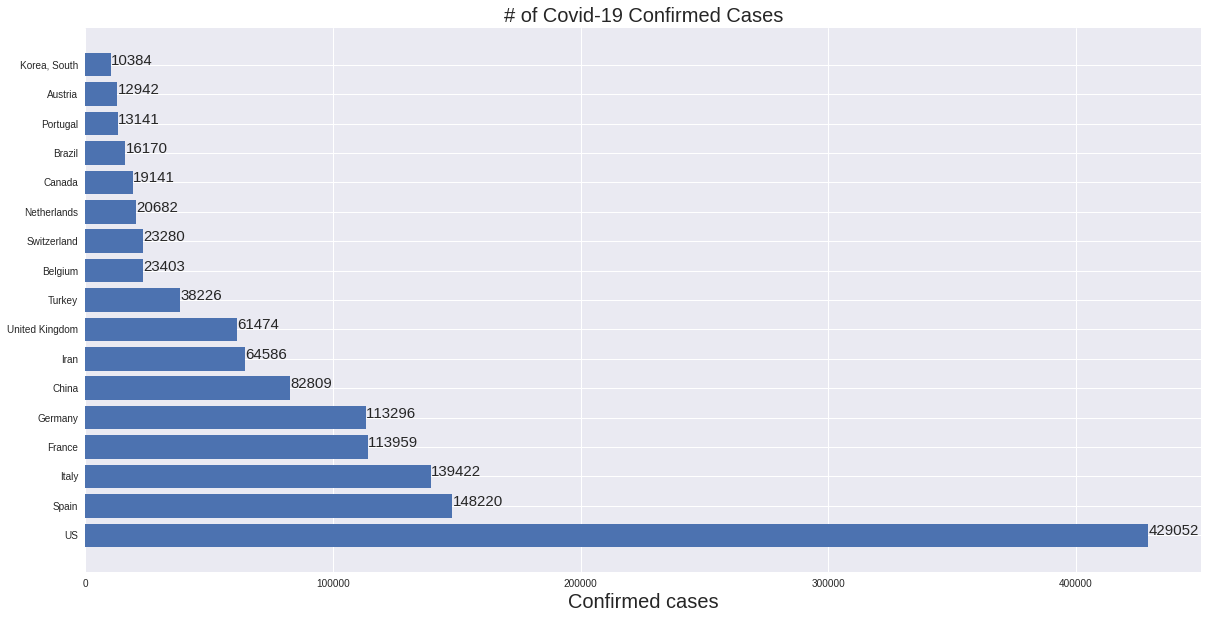

In [9]:
plt.figure(figsize=(20, 10))
plt.barh(visual_unique_countries, visual_confirmed_cases)
plt.xlabel('Confirmed cases', size=20)
plt.title('# of Covid-19 Confirmed Cases', size=20)
for i, case in enumerate(visual_confirmed_cases):
  plt.annotate(xy=[case + 100,i], s=case, size=15)


인구 수 10만명 당 확진자 수

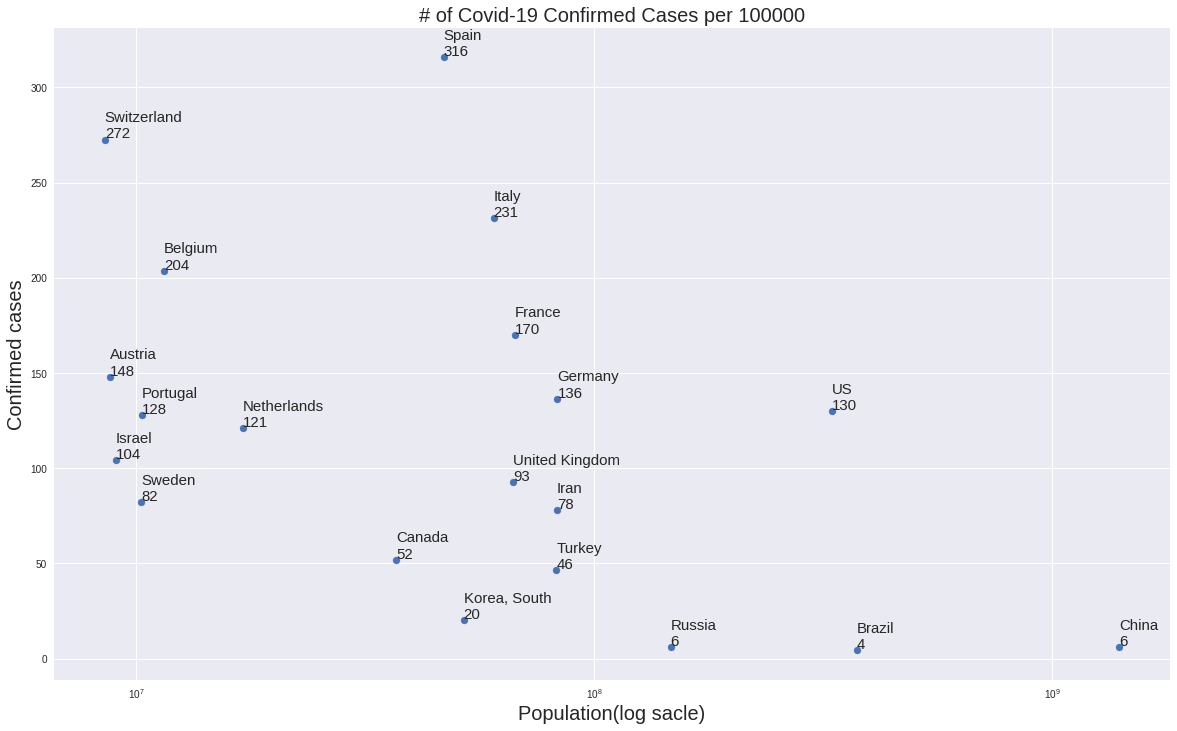

In [10]:
plt.figure(figsize=(20, 12))
v_unique_countries = unique_countries[:20]
#v_unique_countries = visual_unique_countries + ['Japan']
visual_confirmed_cases = []
for i in range(len(v_unique_countries)):
    visual_confirmed_cases.append(latest_confirmed[confirmed_df['Country/Region'] == v_unique_countries[i]].sum())
population_confirmed_cases = []
populations = []
for country, case in zip(v_unique_countries, visual_confirmed_cases):
  population_confirmed_cases.append(case * 100000 / population[country])
  populations.append(population[country])
# plt.bar(v_unique_countries, population_confirmed_cases)
# plt.xlabel('Country', size=20)
# for i, case in enumerate(population_confirmed_cases):
#   plt.annotate(xy=[i, case + 1], s='{:.0f}'.format(case), size=20)
plt.xlabel('Population(log sacle)', size=20)
plt.ylabel('Confirmed cases', size=20)
plt.xscale('log')
plt.scatter(populations, population_confirmed_cases)
plt.title('# of Covid-19 Confirmed Cases per 100000', size=20)
for c, p, case in zip(v_unique_countries, populations, population_confirmed_cases):
  plt.annotate(xy=[p, case + 1], s='{}\n{:.0f}'.format(c, case), size=15)

국가별 사망률

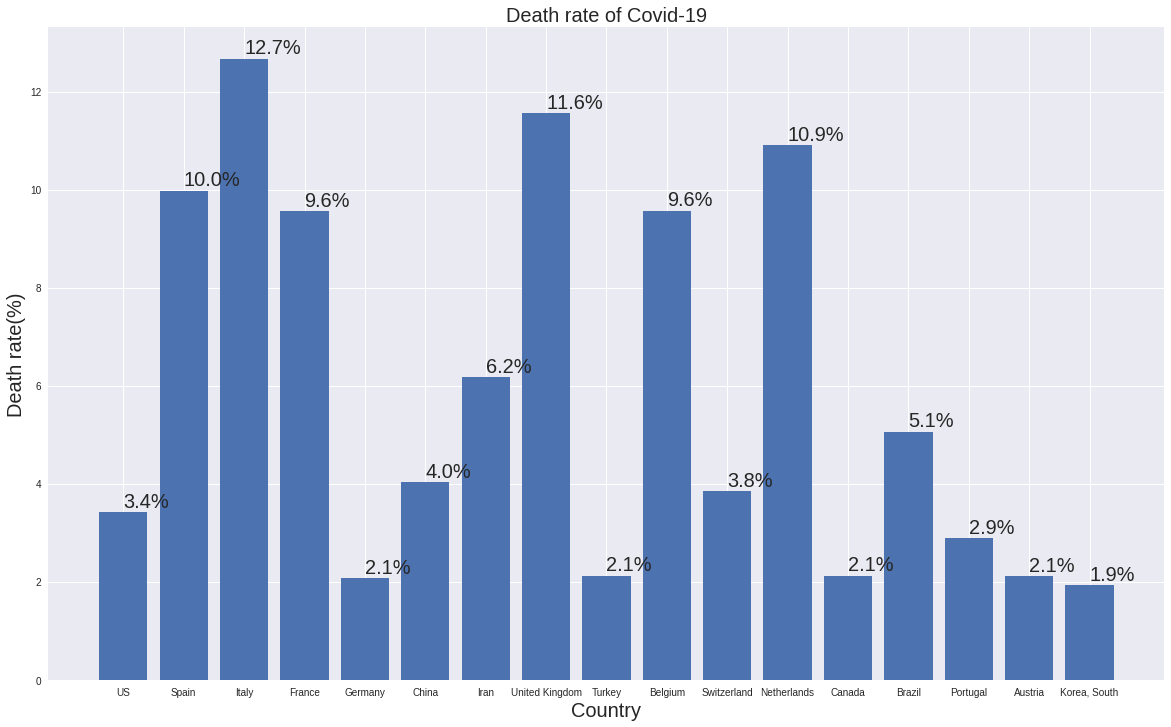

In [11]:
plt.figure(figsize=(20, 12))
v_unique_countries = visual_unique_countries
# v_unique_countries = visual_unique_countries + ['Japan']
visual_confirmed_cases = []
for i in range(len(v_unique_countries)):
    visual_confirmed_cases.append(latest_confirmed[confirmed_df['Country/Region'] == v_unique_countries[i]].sum())
death_ratios = []
for i in range(len(v_unique_countries)):
  ratio = (latest_deaths[deaths_df['Country/Region'] == v_unique_countries[i]].sum() * 100)  / latest_confirmed[confirmed_df['Country/Region'] == v_unique_countries[i]].sum()
  death_ratios.append(ratio)

plt.bar(v_unique_countries, death_ratios)
plt.xlabel('Country', size=20)
plt.ylabel('Death rate(%)', size=20)
plt.title('Death rate of Covid-19', size=20)
for i, ratio in enumerate(death_ratios):
  plt.annotate(xy=[i, ratio + 0.1], s='{:.1f}%'.format(ratio), size=20)


국가별 확진자 상대 비율(파이 챠트)

Text(0.5, 1.0, 'Ratio of Covid-19 Confirmed Cases')

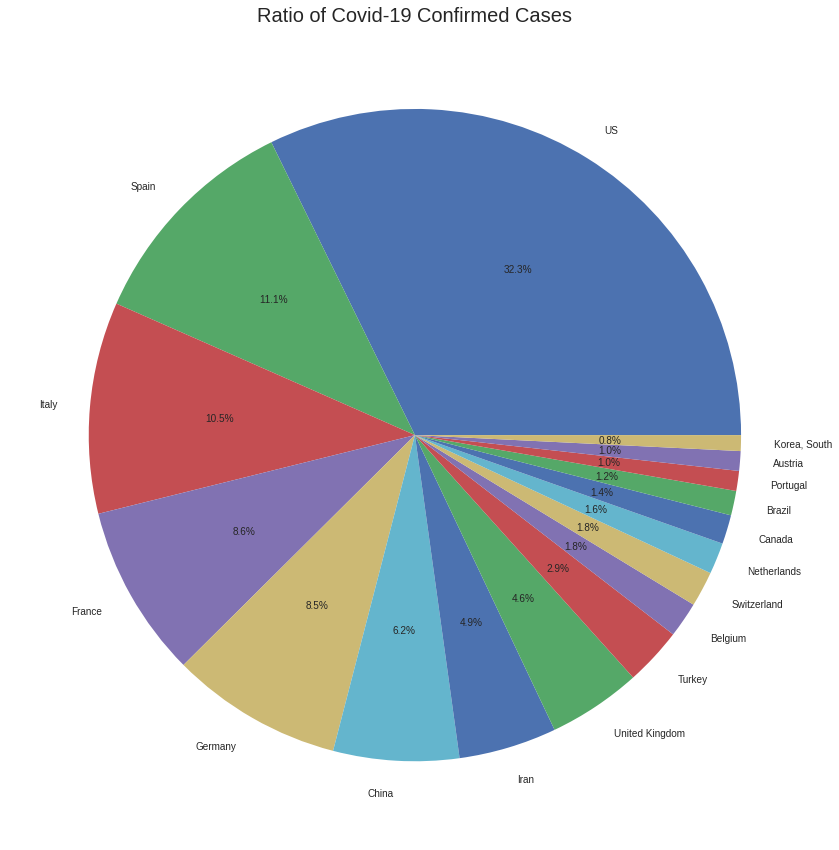

In [12]:
plt.figure(figsize=(20, 15))
plt.pie(visual_confirmed_cases, labels=visual_unique_countries,autopct='%1.1f%%')
plt.title('Ratio of Covid-19 Confirmed Cases', size=20)

전체 누적 확진자 및 신규 확진자

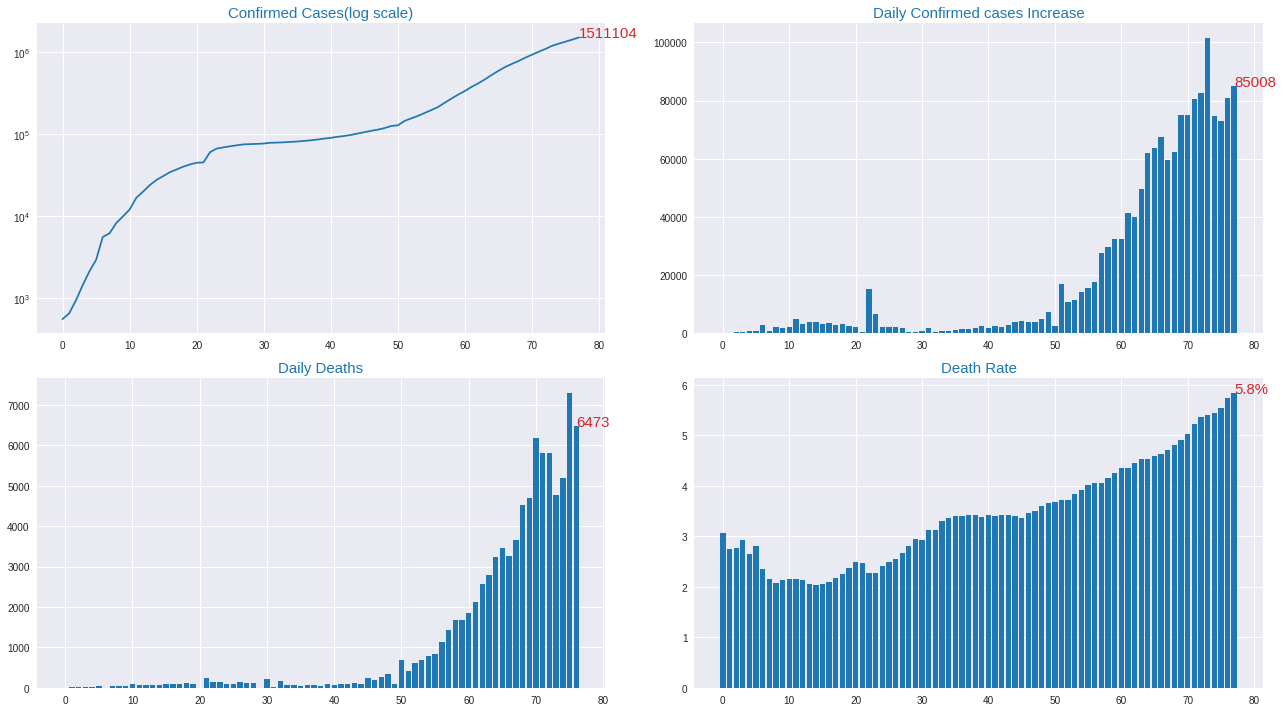

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
total_cases = confirmed.sum()
new_cases =[0]
for i, case in enumerate(total_cases[:-1]):
  new_cases.append(total_cases[i + 1] - total_cases[i])
new_cases = new_cases
color = 'tab:blue'
adjusted_dates = [i for i in range(len(dates))]
axs[0, 0].set_yscale('log')
axs[0, 0].plot(adjusted_dates, total_cases, color=color)
axs[0, 0].set_title('Confirmed Cases(log scale)', size=15, color=color)
axs[0, 0].text(adjusted_dates[-1], total_cases[-1], total_cases[-1],size=15, color='tab:red')

adjusted_dates = [i for i in range(len(new_cases))]
axs[0, 1].bar(adjusted_dates, new_cases, color=color)
axs[0, 1].set_title('Daily Confirmed cases Increase', size=15, color=color)
axs[0, 1].text(adjusted_dates[-1], new_cases[-1], new_cases[-1],size=15, color='tab:red')

total_deaths = deaths.sum()
death_ratios = [(d * 100 / c) for c, d in zip(total_cases, total_deaths)]
total_deaths = [death for death in total_deaths if death > 0]
new_deaths =[]
for i, case in enumerate(total_deaths[:-1]):
  new_deaths.append(total_deaths[i + 1] - total_deaths[i])
adjusted_dates = [i for i in range(len(new_deaths))]
axs[1, 0].bar(adjusted_dates, new_deaths, color=color)
axs[1, 0].set_title('Daily Deaths', size=15, color=color)
axs[1, 0].text(adjusted_dates[-1], new_deaths[-1], new_deaths[-1],size=15, color='tab:red')

adjusted_dates = [i for i in range(len(death_ratios))]
axs[1, 1].bar(adjusted_dates, death_ratios, color=color)
axs[1, 1].set_title('Death Rate', size=15, color=color)
axs[1, 1].text(adjusted_dates[-1], death_ratios[-1], '{:.1f}%'.format(death_ratios[-1]),size=15, color='tab:red')

fig.tight_layout()


국가별 신규 확진자 추이

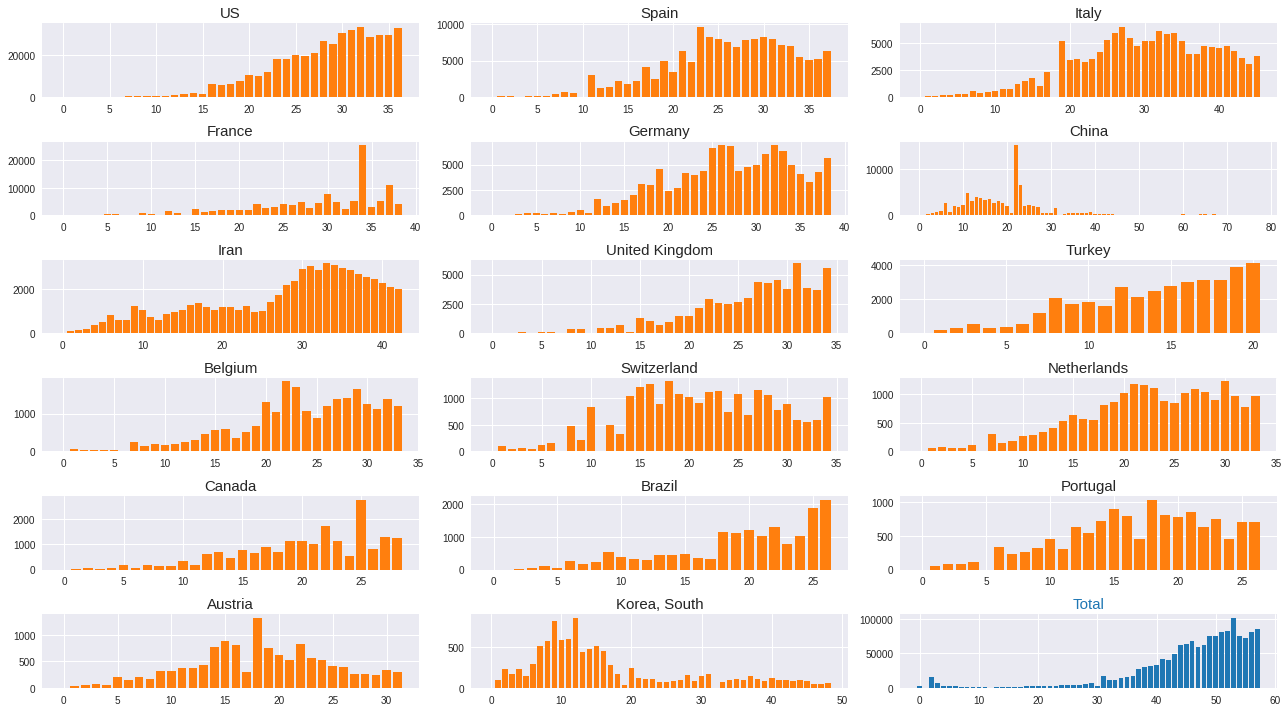

In [14]:
color = 'tab:orange'
fig, axs = plt.subplots(6, 3, figsize=(18, 10))
#fig.suptitle('# of Covid-19 Daily Increase', size=10)
for index, country in enumerate(v_unique_countries):
  cases = confirmed_df.loc[confirmed_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
  cases = [c for c in cases if c > 100]
  adjusted_dates = [i for i in range(len(cases))]
  new_cases =[0]
  for i, case in enumerate(cases[:-1]):
    new_cases.append(cases[i + 1] - cases[i])
  row, col = divmod(index, 3)
  axs[row, col].bar(adjusted_dates, new_cases, color=color)
  axs[row, col].set_title(country, size=15)

total_cases = confirmed.sum()
new_cases =[0]
for i, case in enumerate(total_cases[:-1]):
  new_cases.append(total_cases[i + 1] - total_cases[i])
new_cases = new_cases[20:]
adjusted_dates = [i for i in range(len(new_cases))]
color = 'tab:blue'
axs[5, 2].bar(adjusted_dates, new_cases, color=color)
axs[5, 2].set_title('Total', size=15, color=color)

fig.tight_layout()

국가별 누적 확진자 증가율

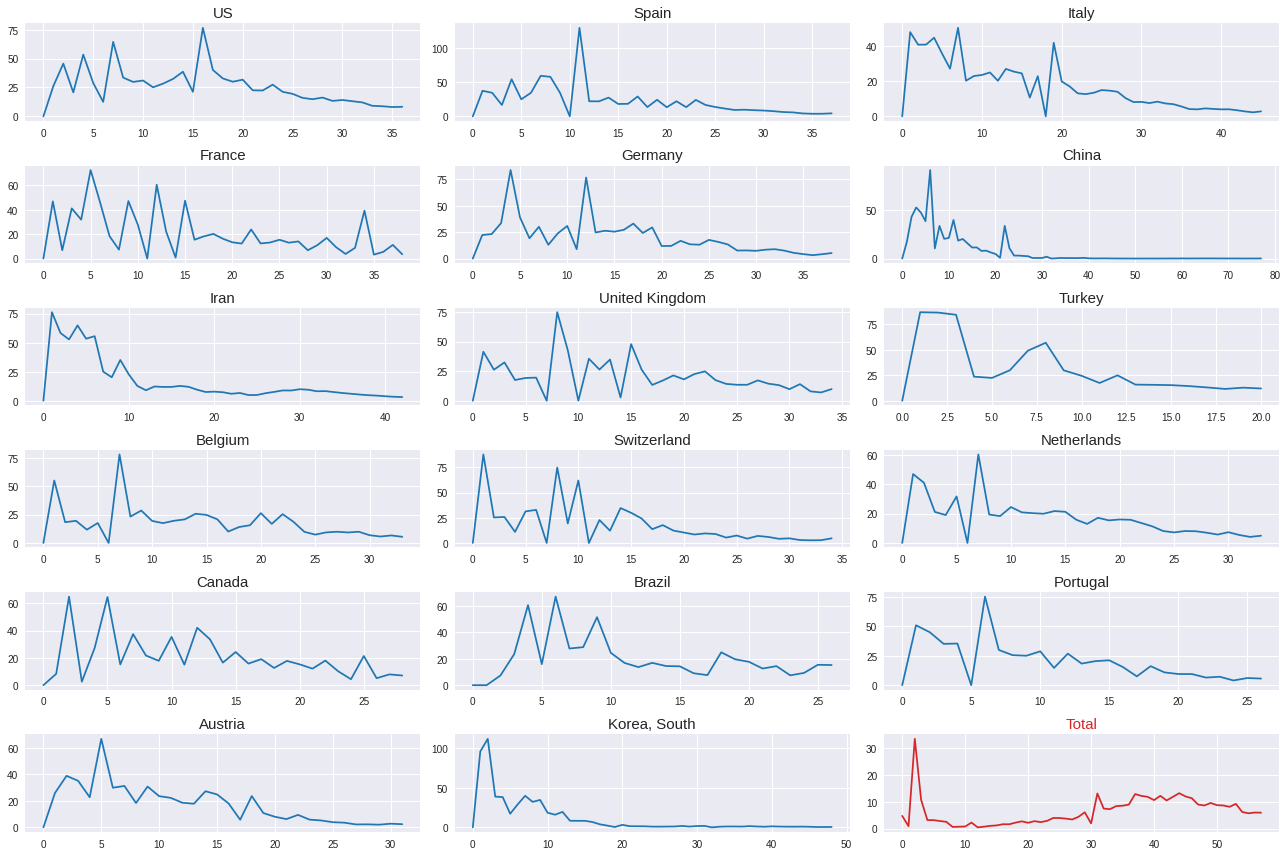

In [15]:
color = 'tab:blue'
fig, axs = plt.subplots(6, 3, figsize=(18, 12))
#fig.suptitle('# of Covid-19 Daily Increase', size=10)
for index, country in enumerate(v_unique_countries):
  cases = confirmed_df.loc[confirmed_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
  cases = [c for c in cases if c > 100]
  adjusted_dates = [i for i in range(len(cases))]
  new_cases =[0]
  for i, case in enumerate(cases[:-1]):
    new_cases.append((cases[i + 1] - cases[i]) * 100 / cases[i])
  row, col = divmod(index, 3)
  axs[row, col].plot(adjusted_dates, new_cases, color=color)
  axs[row, col].set_title(country, size=15)

total_cases = confirmed.sum()
new_cases =[0]
for i, case in enumerate(total_cases[:-1]):
  new_cases.append((total_cases[i + 1] - total_cases[i]) * 100 /total_cases[i])
new_cases = new_cases[20:]
adjusted_dates = [i for i in range(len(new_cases))]
color = 'tab:red'
axs[5, 2].plot(adjusted_dates, new_cases, color=color)
axs[5, 2].set_title('Total', size=15, color=color)

fig.tight_layout()

국가별 일일 사망률 추이

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12., 14.]),
 <a list of 9 Text major ticklabel objects>)

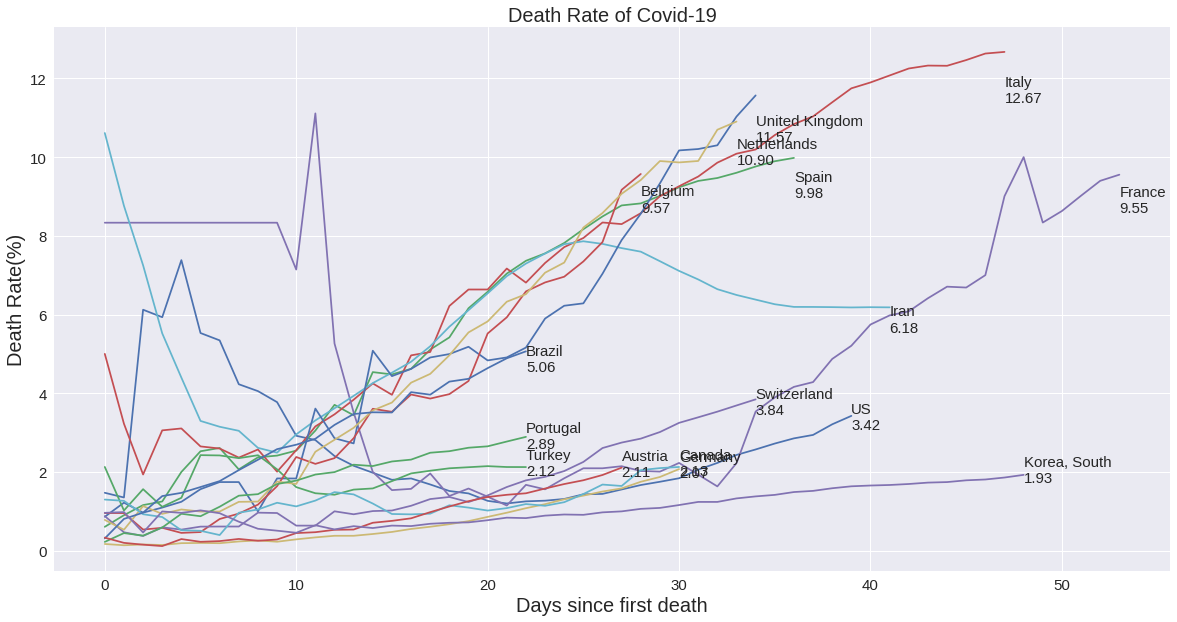

In [16]:
plt.figure(figsize=(20, 10))
for country in v_unique_countries:
  if country == 'China':
    continue
  cases = confirmed_df.loc[confirmed_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
  death_cases = deaths_df.loc[deaths_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
  deaths_ratio =[]
  for i, case in enumerate(cases):
    deaths_ratio.append(death_cases[i] * 100 / cases[i])
  deaths_ratio = [d for d in deaths_ratio if 0 < d < 13]
  adjusted_dates = [i for i in range(len(deaths_ratio))]
  plt.plot(deaths_ratio)
  plt.annotate(xy=[len(deaths_ratio)-1,deaths_ratio[-1] * 0.9], s=country + '\n' + '{:.2f}'.format(deaths_ratio[-1]), size=15)
plt.title('Death Rate of Covid-19', size=20)
plt.xlabel('Days since first death', size=20)
plt.ylabel('Death Rate(%)', size=20)
plt.xticks(size=15)
plt.yticks(size=15)

국가별 사망자 수 추이

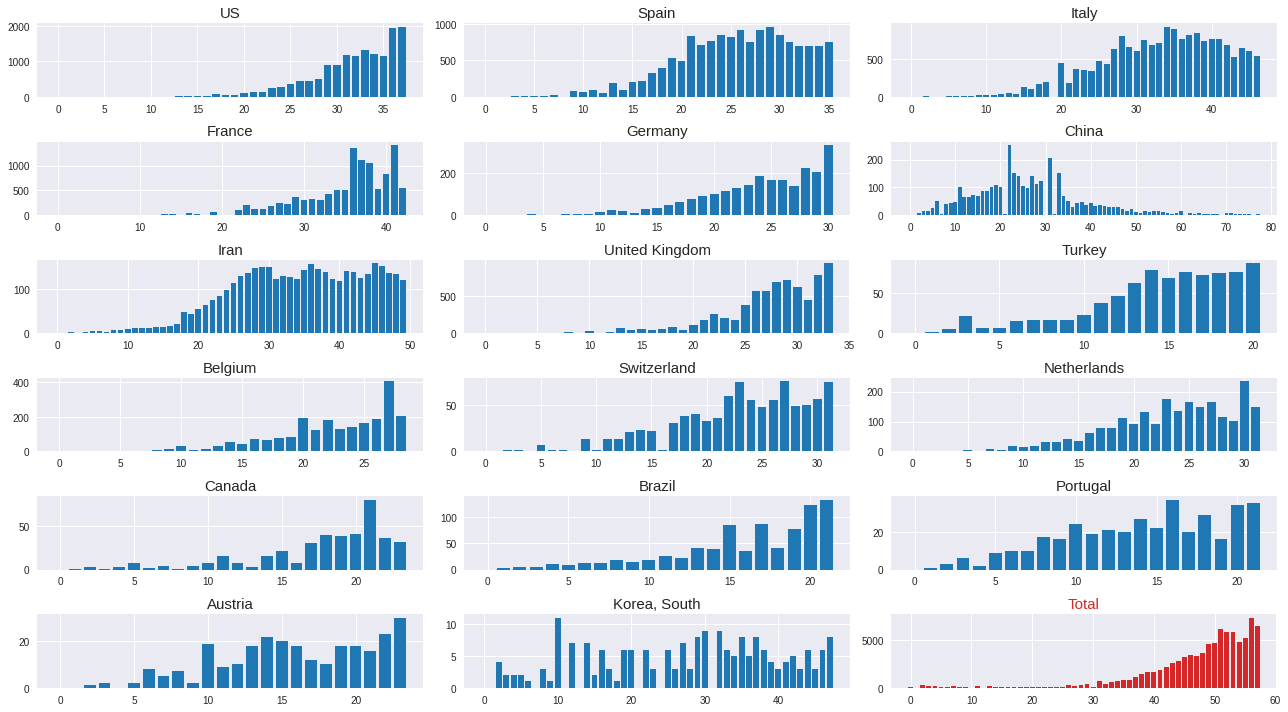

In [17]:
color = 'tab:blue'
fig, axs = plt.subplots(6, 3, figsize=(18, 10))
#fig.suptitle('# of Covid-19 Daily Increase', size=10)
for index, country in enumerate(v_unique_countries):
  cases = deaths_df.loc[confirmed_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
  cases = [c for c in cases if c > 1]
  adjusted_dates = [i for i in range(len(cases))]
  new_cases =[0]
  for i, case in enumerate(cases[:-1]):
    new_cases.append(cases[i + 1] - cases[i])
  row, col = divmod(index, 3)
  axs[row, col].bar(adjusted_dates, new_cases, color=color)
  axs[row, col].set_title(country, size=15)

total_cases = deaths.sum()
new_cases =[0]
for i, case in enumerate(total_cases[:-1]):
  new_cases.append(total_cases[i + 1] - total_cases[i])
new_cases = new_cases[20:]
adjusted_dates = [i for i in range(len(new_cases))]
color = 'tab:red'
axs[5, 2].bar(adjusted_dates, new_cases, color=color)
axs[5, 2].set_title('Total', size=15, color=color)

fig.tight_layout()

이탈리아 현황

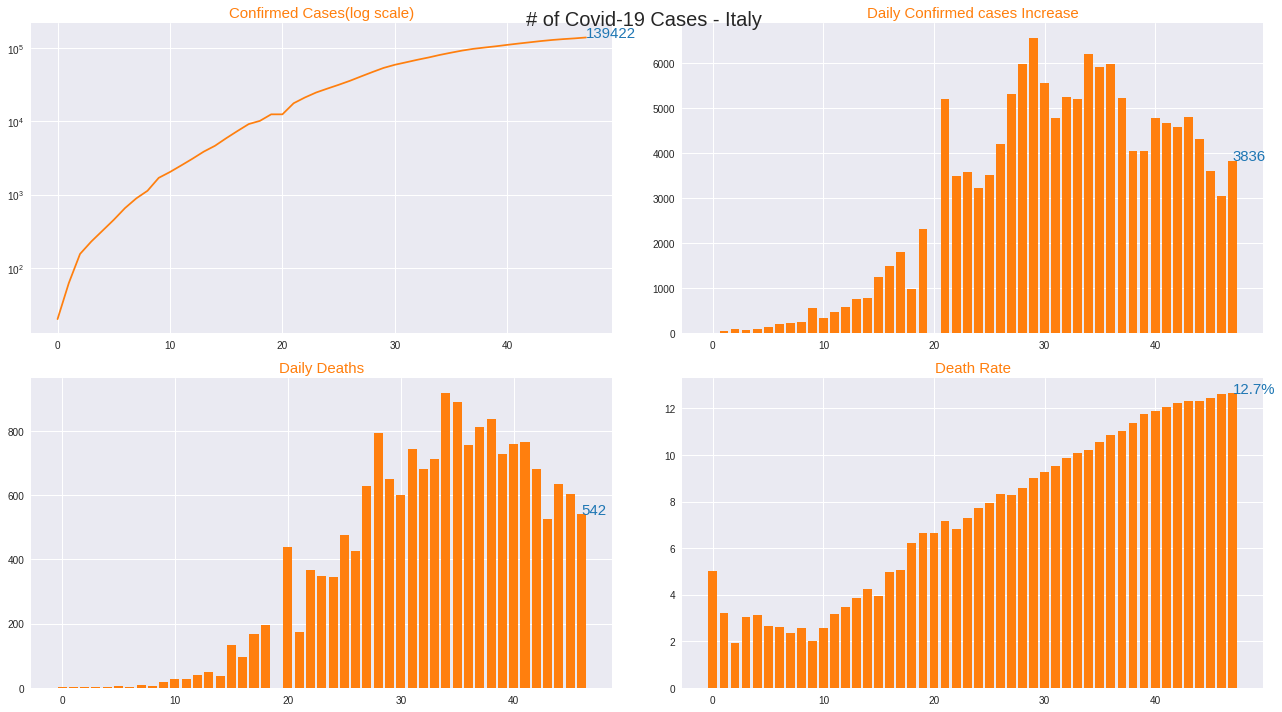

In [18]:
country = 'Italy'
start = 30
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('# of Covid-19 Cases - Italy', size=20)
total_cases = confirmed_df.loc[confirmed_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
total_cases = total_cases.values.reshape(len(dates))
total_cases = total_cases[start:]
new_cases =[0]
for i, case in enumerate(total_cases[:-1]):
  new_cases.append(total_cases[i + 1] - total_cases[i])
new_cases = new_cases
color = 'tab:orange'
adjusted_dates = [i for i in range(len(total_cases))]
axs[0, 0].set_yscale('log')
axs[0, 0].plot(adjusted_dates, total_cases, color=color)
axs[0, 0].set_title('Confirmed Cases(log scale)', size=15, color=color)
axs[0, 0].text(adjusted_dates[-1], total_cases[-1], total_cases[-1],size=15, color='tab:blue')

adjusted_dates = [i for i in range(len(new_cases))]
axs[0, 1].bar(adjusted_dates, new_cases, color=color)
axs[0, 1].set_title('Daily Confirmed cases Increase', size=15, color=color)
axs[0, 1].text(adjusted_dates[-1], new_cases[-1], new_cases[-1],size=15, color='tab:blue')

total_deaths = deaths_df.loc[deaths_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
total_deaths = total_deaths.values.reshape(len(dates))
total_deaths = total_deaths[start:]
death_ratios = [(d * 100 / c) for c, d in zip(total_cases, total_deaths)]
total_deaths = [death for death in total_deaths if death > 0]
new_deaths =[]
for i, case in enumerate(total_deaths[:-1]):
  new_deaths.append(total_deaths[i + 1] - total_deaths[i])
adjusted_dates = [i for i in range(len(new_deaths))]
axs[1, 0].bar(adjusted_dates, new_deaths, color=color)
axs[1, 0].set_title('Daily Deaths', size=15, color=color)
axs[1, 0].text(adjusted_dates[-1], new_deaths[-1], new_deaths[-1],size=15, color='tab:blue')

adjusted_dates = [i for i in range(len(death_ratios))]
axs[1, 1].bar(adjusted_dates, death_ratios, color=color)
axs[1, 1].set_title('Death Rate', size=15, color=color)
axs[1, 1].text(adjusted_dates[-1], death_ratios[-1], '{:.1f}%'.format(death_ratios[-1]),size=15, color='tab:blue')

fig.tight_layout()


미국 추이

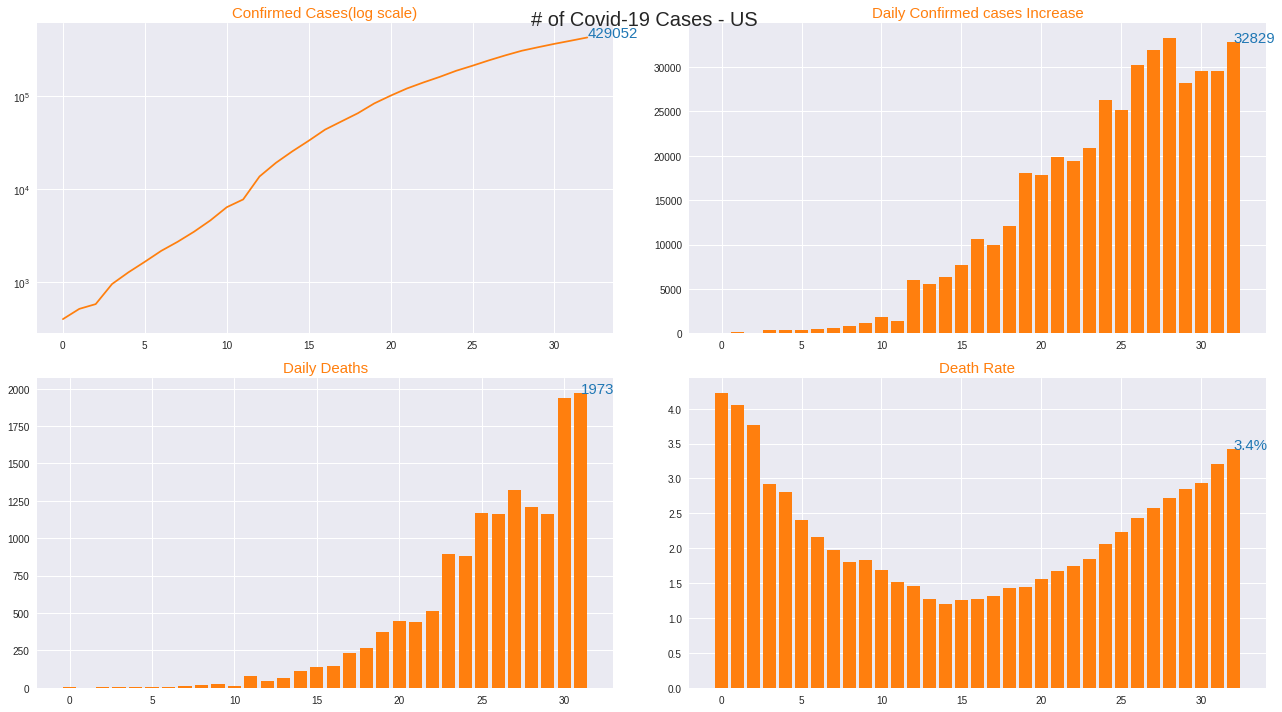

In [19]:
country = 'US'
start = 45
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('# of Covid-19 Cases - US', size=20)
total_cases = confirmed_df.loc[confirmed_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
total_cases = total_cases.values.reshape(len(dates))
total_cases = total_cases[start:]
new_cases =[0]
for i, case in enumerate(total_cases[:-1]):
  new_cases.append(total_cases[i + 1] - total_cases[i])
new_cases = new_cases
color = 'tab:orange'
adjusted_dates = [i for i in range(len(total_cases))]
axs[0, 0].set_yscale('log')
axs[0, 0].plot(adjusted_dates, total_cases, color=color)
axs[0, 0].set_title('Confirmed Cases(log scale)', size=15, color=color)
axs[0, 0].text(adjusted_dates[-1], total_cases[-1], total_cases[-1],size=15, color='tab:blue')

adjusted_dates = [i for i in range(len(new_cases))]
axs[0, 1].bar(adjusted_dates, new_cases, color=color)
axs[0, 1].set_title('Daily Confirmed cases Increase', size=15, color=color)
axs[0, 1].text(adjusted_dates[-1], new_cases[-1], new_cases[-1],size=15, color='tab:blue')

total_deaths = deaths_df.loc[deaths_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
total_deaths = total_deaths.values.reshape(len(dates))
total_deaths = total_deaths[start:]
death_ratios = [(d * 100 / c) for c, d in zip(total_cases, total_deaths)]
total_deaths = [death for death in total_deaths if death > 0]
new_deaths =[]
for i, case in enumerate(total_deaths[:-1]):
  new_deaths.append(total_deaths[i + 1] - total_deaths[i])
adjusted_dates = [i for i in range(len(new_deaths))]
axs[1, 0].bar(adjusted_dates, new_deaths, color=color)
axs[1, 0].set_title('Daily Deaths', size=15, color=color)
axs[1, 0].text(adjusted_dates[-1], new_deaths[-1], new_deaths[-1],size=15, color='tab:blue')

adjusted_dates = [i for i in range(len(death_ratios))]
axs[1, 1].bar(adjusted_dates, death_ratios, color=color)
axs[1, 1].set_title('Death Rate', size=15, color=color)
axs[1, 1].text(adjusted_dates[-1], death_ratios[-1], '{:.1f}%'.format(death_ratios[-1]),size=15, color='tab:blue')

fig.tight_layout()


일본 현황

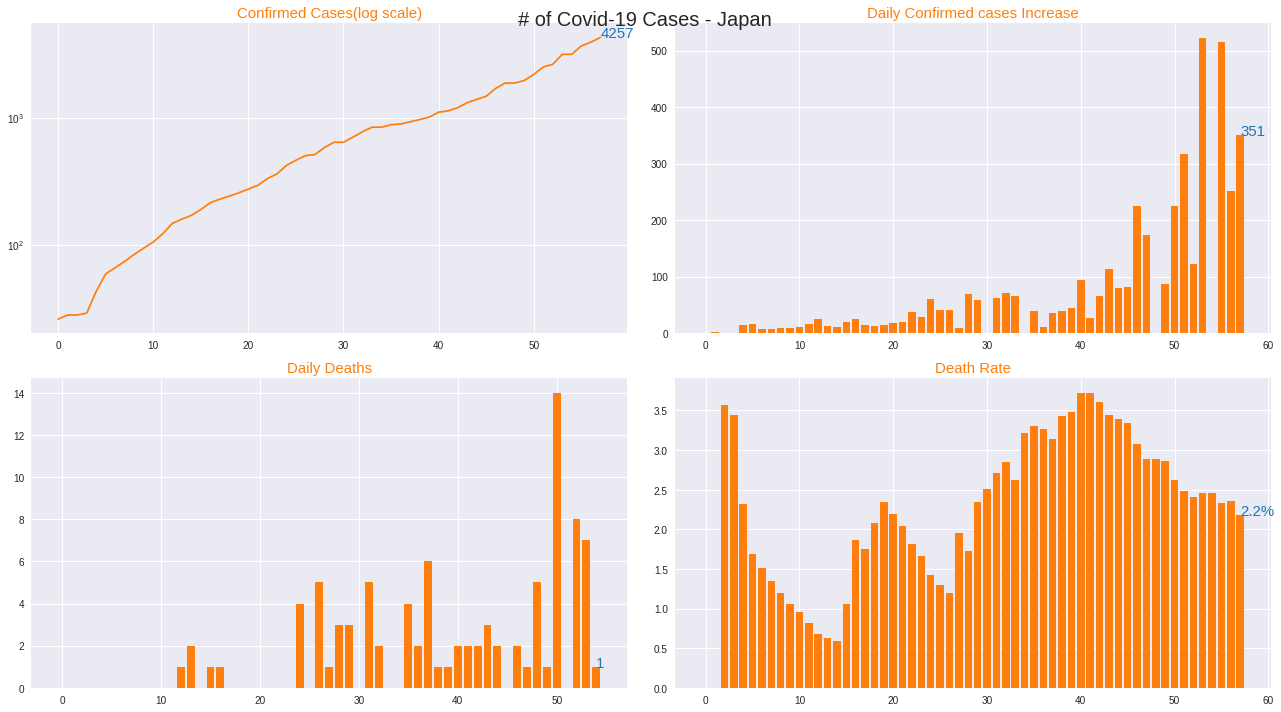

In [20]:
country = 'Japan'
start = 20
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('# of Covid-19 Cases - Japan', size=20)
total_cases = confirmed_df.loc[confirmed_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
total_cases = total_cases.values.reshape(len(dates))
total_cases = total_cases[start:]
new_cases =[0]
for i, case in enumerate(total_cases[:-1]):
  new_cases.append(total_cases[i + 1] - total_cases[i])
new_cases = new_cases
color = 'tab:orange'
adjusted_dates = [i for i in range(len(total_cases))]
axs[0, 0].set_yscale('log')
axs[0, 0].plot(adjusted_dates, total_cases, color=color)
axs[0, 0].set_title('Confirmed Cases(log scale)', size=15, color=color)
axs[0, 0].text(adjusted_dates[-1], total_cases[-1], total_cases[-1],size=15, color='tab:blue')

adjusted_dates = [i for i in range(len(new_cases))]
axs[0, 1].bar(adjusted_dates, new_cases, color=color)
axs[0, 1].set_title('Daily Confirmed cases Increase', size=15, color=color)
axs[0, 1].text(adjusted_dates[-1], new_cases[-1], new_cases[-1],size=15, color='tab:blue')

total_deaths = deaths_df.loc[deaths_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
total_deaths = total_deaths.values.reshape(len(dates))
total_deaths = total_deaths[start:]
death_ratios = [(d * 100 / c) for c, d in zip(total_cases, total_deaths)]
total_deaths = [death for death in total_deaths if death > 0]
new_deaths =[]
for i, case in enumerate(total_deaths[:-1]):
  new_deaths.append(total_deaths[i + 1] - total_deaths[i])
adjusted_dates = [i for i in range(len(new_deaths))]
axs[1, 0].bar(adjusted_dates, new_deaths, color=color)
axs[1, 0].set_title('Daily Deaths', size=15, color=color)
axs[1, 0].text(adjusted_dates[-1], new_deaths[-1], new_deaths[-1],size=15, color='tab:blue')

adjusted_dates = [i for i in range(len(death_ratios))]
axs[1, 1].bar(adjusted_dates, death_ratios, color=color)
axs[1, 1].set_title('Death Rate', size=15, color=color)
axs[1, 1].text(adjusted_dates[-1], death_ratios[-1], '{:.1f}%'.format(death_ratios[-1]),size=15, color='tab:blue')

fig.tight_layout()


국가별,일별 누적 확진자 그래프(중국 제외)


(array([-100000.,       0.,  100000.,  200000.,  300000.,  400000.,
         500000.]), <a list of 7 Text major ticklabel objects>)

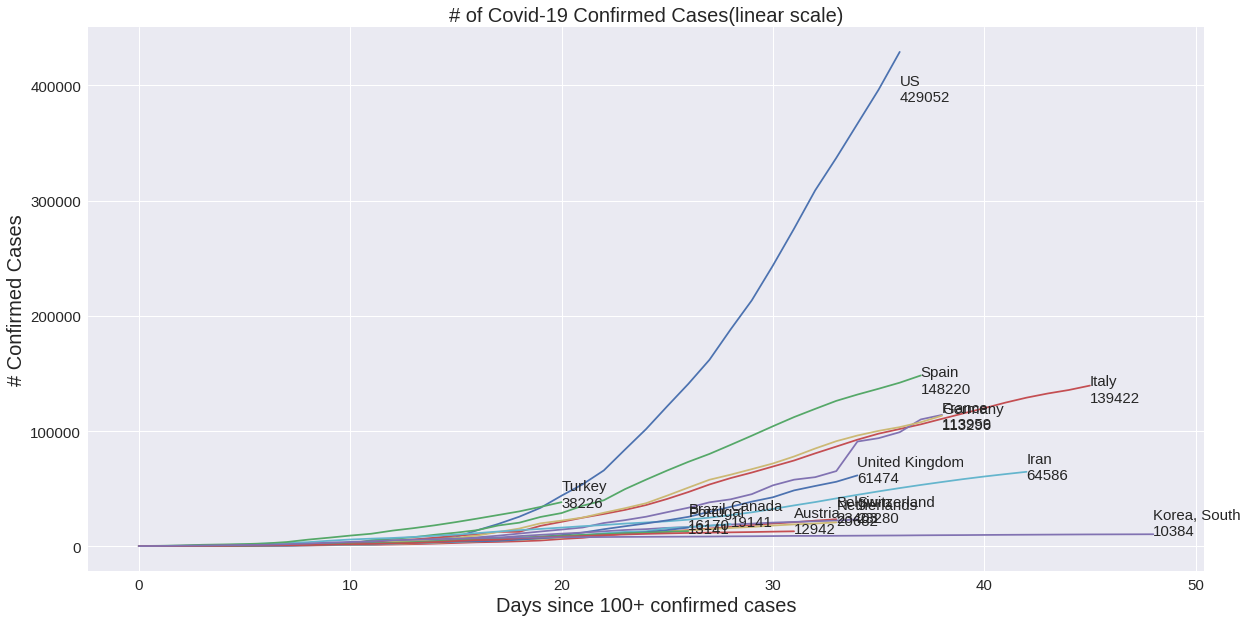

In [21]:
plt.figure(figsize=(20, 10))
for country in v_unique_countries:
  if country == 'China':
    continue
  country_confirmed_cases = confirmed_df.loc[confirmed_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
  country_confirmed_cases = country_confirmed_cases.values.reshape(len(dates))
  country_confirmed_cases = [confirmed for confirmed in country_confirmed_cases if confirmed > 100]
  plt.plot(country_confirmed_cases)
  plt.annotate(xy=[len(country_confirmed_cases)-1,country_confirmed_cases[-1] * 0.9], s=country + '\n' + str(country_confirmed_cases[-1]), size=15)
plt.title('# of Covid-19 Confirmed Cases(linear scale)', size=20)
plt.xlabel('Days since 100+ confirmed cases', size=20)
plt.ylabel('# Confirmed Cases', size=20)
plt.xticks(size=15)
plt.yticks(size=15)


확진자 100명 이후 경과일수에 따른 확진자 추이(중국 제외)

(array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07]),
 <a list of 8 Text major ticklabel objects>)

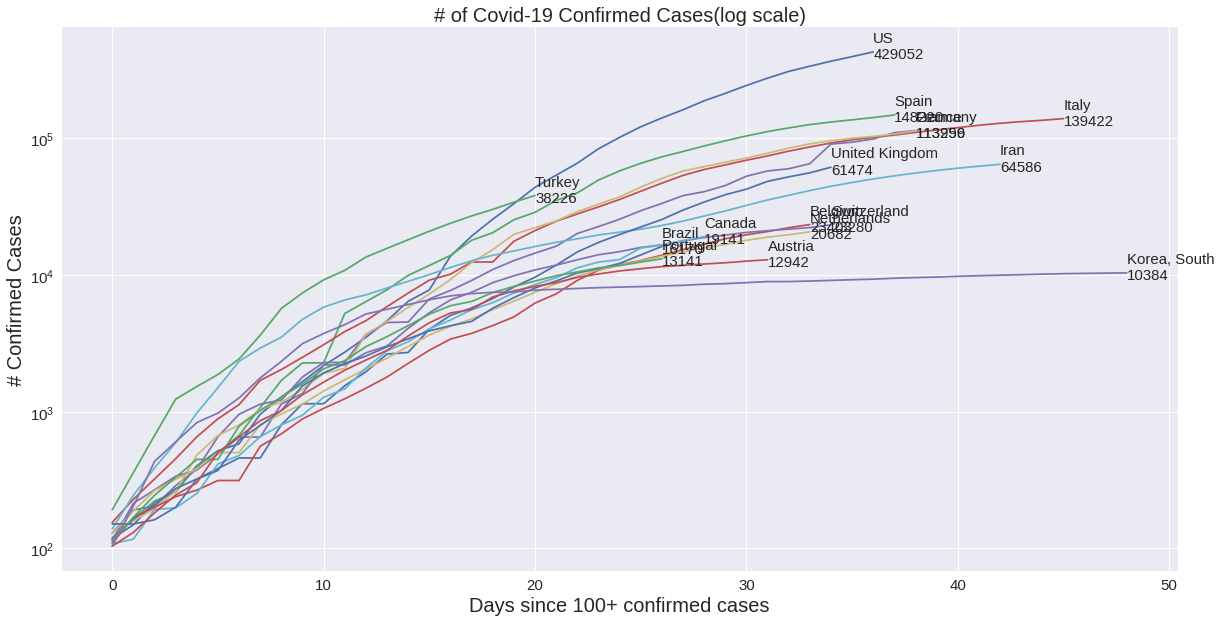

In [22]:
plt.figure(figsize=(20, 10))
plt.yscale('log')
for country in v_unique_countries:
  if country == 'China':
    continue
  country_confirmed_cases = confirmed_df.loc[confirmed_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
  country_confirmed_cases = country_confirmed_cases.values.reshape(len(dates))
  country_confirmed_cases = [confirmed for confirmed in country_confirmed_cases if confirmed > 100]
  plt.plot(country_confirmed_cases)
  plt.annotate(xy=[len(country_confirmed_cases)-1,country_confirmed_cases[-1] * 0.9], s=country + '\n' + str(country_confirmed_cases[-1]), size=15)
plt.title('# of Covid-19 Confirmed Cases(log scale)', size=20)
plt.xlabel('Days since 100+ confirmed cases', size=20)
plt.ylabel('# Confirmed Cases', size=20)
# plt.legend(v_unique_countries, loc='upper left')
plt.xticks(size=15)
plt.yticks(size=15)

국내 확진자/격리중/완치자/사망자

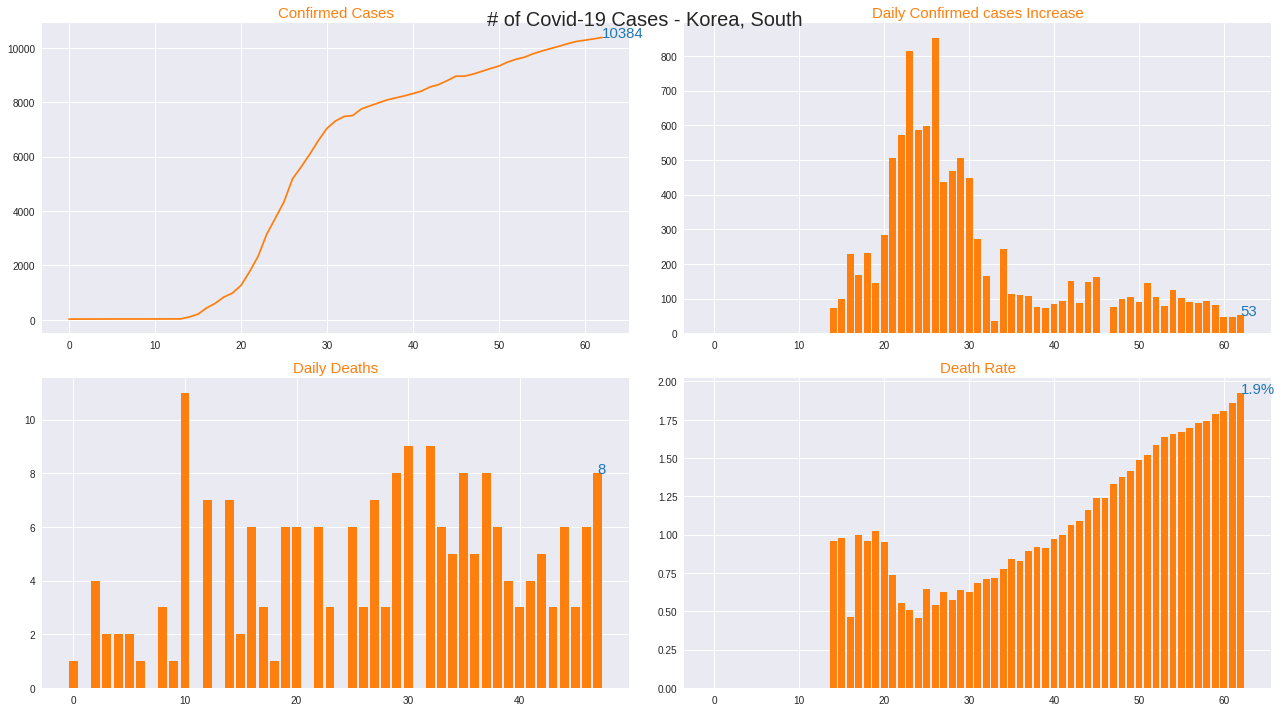

In [23]:
# country = 'Korea, South'
# adjusted_dates = np.array([i for i in range(len(dates))]).reshape(-1, 1)
# adjusted_dates = adjusted_dates[20:]
# plt.figure(figsize=(20, 7))
# country_confirmed_cases = confirmed_df.loc[confirmed_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
# country_confirmed_cases = country_confirmed_cases.values.reshape(len(dates))
# plt.plot(adjusted_dates, country_confirmed_cases[20:])

# country_recovered_cases = recoveries_df.loc[recoveries_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
# country_recovered_cases = country_recovered_cases.values.reshape(len(dates))
# plt.plot(adjusted_dates, country_recovered_cases[20:])

# country_deaths_cases = deaths_df.loc[deaths_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
# country_deaths_cases = country_deaths_cases.values.reshape(len(dates))
# plt.plot(adjusted_dates, country_deaths_cases[20:])

# infected = [(confirmed - recovered - death) for confirmed, recovered, death in zip(country_confirmed_cases, country_recovered_cases, country_deaths_cases)]
# plt.plot(adjusted_dates, infected[20:])

# plt.title('# of Covid-19 Cases - Korea, South', size=20)
# plt.xlabel('Days since 1/22/2020', size=20)
# plt.ylabel('# Cases', size=20)
# plt.annotate(xy=(len(dates)-1, country_confirmed_cases[-1]*0.95), s='Confirmed\n{}'.format(country_confirmed_cases[-1]), size=15)
# plt.annotate(xy=(len(dates)-1, country_recovered_cases[-1]*0.95), s='Recovered\n{}'.format(country_recovered_cases[-1]), size=15)
# plt.annotate(xy=(len(dates)-1, country_deaths_cases[-1]*0.95), s='Deaths\n{}'.format(country_deaths_cases[-1]), size=15)
# plt.annotate(xy=(len(dates)-1, infected[-1]*0.95), s='Not recovered\n{}'.format(infected[-1]), size=15)
# plt.xticks(size=15)


country = 'Korea, South'
start = 15
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('# of Covid-19 Cases - Korea, South', size=20)
total_cases = confirmed_df.loc[confirmed_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
total_cases = total_cases.values.reshape(len(dates))
total_cases = total_cases[start:]
new_cases =[0]
for i, case in enumerate(total_cases[:-1]):
  new_cases.append(total_cases[i + 1] - total_cases[i])
new_cases = new_cases
color = 'tab:orange'
adjusted_dates = [i for i in range(len(total_cases))]
#axs[0, 0].set_yscale('log')
axs[0, 0].plot(adjusted_dates, total_cases, color=color)
axs[0, 0].set_title('Confirmed Cases', size=15, color=color)
axs[0, 0].text(adjusted_dates[-1], total_cases[-1], total_cases[-1],size=15, color='tab:blue')

adjusted_dates = [i for i in range(len(new_cases))]
axs[0, 1].bar(adjusted_dates, new_cases, color=color)
axs[0, 1].set_title('Daily Confirmed cases Increase', size=15, color=color)
axs[0, 1].text(adjusted_dates[-1], new_cases[-1], new_cases[-1],size=15, color='tab:blue')

total_deaths = deaths_df.loc[deaths_df['Country/Region'] == country, cols[4]:cols[-1]].sum()
total_deaths = total_deaths.values.reshape(len(dates))
total_deaths = total_deaths[start:]
death_ratios = [(d * 100 / c) for c, d in zip(total_cases, total_deaths)]
total_deaths = [death for death in total_deaths if death > 0]
new_deaths =[]
for i, case in enumerate(total_deaths[:-1]):
  new_deaths.append(total_deaths[i + 1] - total_deaths[i])
adjusted_dates = [i for i in range(len(new_deaths))]
axs[1, 0].bar(adjusted_dates, new_deaths, color=color)
axs[1, 0].set_title('Daily Deaths', size=15, color=color)
axs[1, 0].text(adjusted_dates[-1], new_deaths[-1], new_deaths[-1],size=15, color='tab:blue')

adjusted_dates = [i for i in range(len(death_ratios))]
axs[1, 1].bar(adjusted_dates, death_ratios, color=color)
axs[1, 1].set_title('Death Rate', size=15, color=color)
axs[1, 1].text(adjusted_dates[-1], death_ratios[-1], '{:.1f}%'.format(death_ratios[-1]),size=15, color='tab:blue')

fig.tight_layout()


EU 국가 현황

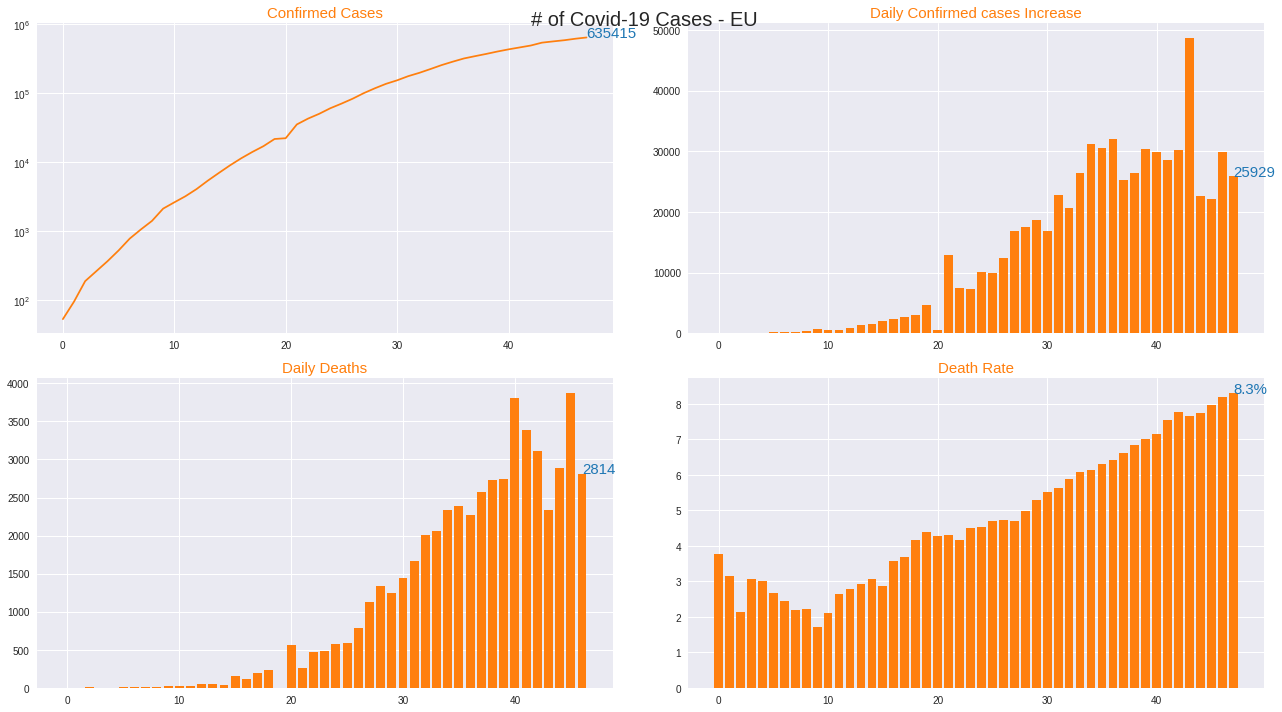

In [24]:

country = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'Greece', 'Hungary', 'Ireland', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 
           'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Sweden', 'Spain', 'Italy', 'Germany', 'France']
start = 30
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('# of Covid-19 Cases - EU', size=20)
total_cases = confirmed_df.loc[confirmed_df['Country/Region'].isin(country), cols[4]:cols[-1]].sum()
total_cases = total_cases.values.reshape(len(dates))
total_cases = total_cases[start:]
new_cases =[0]
for i, case in enumerate(total_cases[:-1]):
  new_cases.append(total_cases[i + 1] - total_cases[i])
new_cases = new_cases
color = 'tab:orange'
adjusted_dates = [i for i in range(len(total_cases))]
axs[0, 0].set_yscale('log')
axs[0, 0].plot(adjusted_dates, total_cases, color=color)
axs[0, 0].set_title('Confirmed Cases', size=15, color=color)
axs[0, 0].text(adjusted_dates[-1], total_cases[-1], total_cases[-1],size=15, color='tab:blue')

adjusted_dates = [i for i in range(len(new_cases))]
axs[0, 1].bar(adjusted_dates, new_cases, color=color)
axs[0, 1].set_title('Daily Confirmed cases Increase', size=15, color=color)
axs[0, 1].text(adjusted_dates[-1], new_cases[-1], new_cases[-1],size=15, color='tab:blue')

total_deaths = deaths_df.loc[deaths_df['Country/Region'].isin(country), cols[4]:cols[-1]].sum()
total_deaths = total_deaths.values.reshape(len(dates))
total_deaths = total_deaths[start:]
death_ratios = [(d * 100 / c) for c, d in zip(total_cases, total_deaths)]
total_deaths = [death for death in total_deaths if death > 0]
new_deaths =[]
for i, case in enumerate(total_deaths[:-1]):
  new_deaths.append(total_deaths[i + 1] - total_deaths[i])
adjusted_dates = [i for i in range(len(new_deaths))]
axs[1, 0].bar(adjusted_dates, new_deaths, color=color)
axs[1, 0].set_title('Daily Deaths', size=15, color=color)
axs[1, 0].text(adjusted_dates[-1], new_deaths[-1], new_deaths[-1],size=15, color='tab:blue')

adjusted_dates = [i for i in range(len(death_ratios))]
axs[1, 1].bar(adjusted_dates, death_ratios, color=color)
axs[1, 1].set_title('Death Rate', size=15, color=color)
axs[1, 1].text(adjusted_dates[-1], death_ratios[-1], '{:.1f}%'.format(death_ratios[-1]),size=15, color='tab:blue')

fig.tight_layout()
